In [ ]:
import pymc as pm
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
from pytensor.tensor.variable import TensorVariable

# Define a simple neural network in PyTorch
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(1, 10)
        self.out = nn.Linear(10, 1)
        
    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.out(x)

# Assume you have a pre-trained model (SimpleNN) - Here we initialize it randomly
neural_network = SimpleNN()
# You might need to load pre-trained weights
# neural_network.load_state_dict(torch.load('path_to_pretrained_weights.pth'))

# Define a wrapper to use the PyTorch model within the PyMC context
def neural_network_likelihood(theta: TensorVariable, x_data):
    # Convert theta and x_data to PyTorch tensors
    theta_tensor = torch.tensor(theta, dtype=torch.float32)
    x_data_tensor = torch.tensor(x_data, dtype=torch.float32)
    
    # Combine them if necessary (depends on your specific setup)
    combined_input = torch.cat([theta_tensor.unsqueeze(0), x_data_tensor.unsqueeze(0)], dim=-1)
    
    # Run through the neural network
    prediction = neural_network(combined_input)
    
    # Return the prediction (convert to numpy if needed)
    return prediction.detach().numpy()

# Now, let's set up the PyMC model
x_data = np.array([2.0])  # Replace this with your actual observed data

with pm.Model() as model:
    # Define the prior: a uniform distribution for `theta`
    theta = pm.Uniform('theta', lower=0, upper=10)
    
    # Likelihood using the neural network (convert to deterministic)
    # Here we use a deterministic node to compute the likelihood
    likelihood_mu = pm.Deterministic('likelihood_mu', neural_network_likelihood(theta, x_data))
    
    # Observed data with some likelihood distribution, e.g., Gaussian around NN output
    # Assume the output of NN is a mean of some Gaussian
    likelihood = pm.Normal('x_obs', mu=likelihood_mu, sigma=1.0, observed=x_data)
    
    # Run the MCMC
    trace = pm.sample(1000, tune=500, return_inferencedata=True)


In [131]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define a simple neural network in PyTorch
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(1, 10)
        self.out = nn.Linear(10, 1)
        
    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.out(x)

# Assume you have a pre-trained model (SimpleNN) - Initialize it randomly here
neural_network = SimpleNN()
# You might want to load pre-trained weights here if available
# neural_network.load_state_dict(torch.load('path_to_pretrained_weights.pth'))

# Define the probabilistic model in Pyro
def model(x_data):
    # Prior for theta, e.g., Uniform between 0 and 10
    theta = pyro.sample('theta', dist.Uniform(0., 10.))
    
    # Use theta to compute the likelihood via the neural network
    theta_tensor = torch.tensor([[theta]])  # Ensure theta is in the right shape
    prediction = neural_network(theta_tensor).squeeze()
    
    # Assume a Gaussian likelihood with the neural network's output as the mean
    pyro.sample('obs', dist.Normal(prediction, 1.0), obs=torch.tensor(x_data))

# Data: observed data, replace this with your real observed data
x_data = torch.tensor([2.0])  # Example observed data

# Set up the MCMC using the NUTS sampler
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500)
mcmc.run(x_data)

# Retrieve the samples
# samples = mcmc.get_samples()
#  print(samples)


Warmup:   0%|          | 0/1500 [00:00, ?it/s]/tmp/ipykernel_202995/2224813286.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pyro.sample('obs', dist.Normal(prediction, 1.0), obs=torch.tensor(x_data))
Warmup:   1%|▏         | 22/1500 [00:07,  1.94it/s, step size=1.53e-03, acc. prob=0.653]]

KeyboardInterrupt: 

In [1]:
import pymc as pm
import numpy as np
import torch
import torch.distributions as dist

# Let's assume `gen_llh_fn` is a function defined elsewhere
# For demonstration, we define a placeholder here:
def gen_llh_fn(theta, x_o):
    # Example log-likelihood computation (you can replace this with your actual function)
    # Here, we assume a simple Gaussian log-likelihood for demonstration
    # Replace it with your actual computation
    mu = torch.tensor([0.0])
    sigma = torch.tensor([1.0])
    likelihood_dist = dist.Normal(mu, sigma)
    log_likelihood = likelihood_dist.log_prob(x_o - theta).sum()
    return log_likelihood

# Define the GBIPotential class
class GBIPotential:
    def __init__(self, prior, gen_llh_fn, x_o=None, beta=1.0):
        self.prior = prior
        self.gen_llh_fn = gen_llh_fn
        self.x_o = x_o
        self.beta = beta

    def set_beta(self, beta):
        self.beta = beta

    def __call__(self, theta, track_gradients=True):
        with torch.set_grad_enabled(track_gradients):
            # Compute the log-prior + log-likelihood
            return -self.beta * self.gen_llh_fn(theta, self.x_o) + self.prior.log_prob(theta)

# Assume you have some observed data
x_o = torch.tensor([2.0])  # Replace this with your actual observed data

# Define the prior for theta using PyTorch
# Here I assume a uniform prior between 0 and 10
prior = dist.Uniform(0., 10.)

# Initialize the GBIPotential with the prior and likelihood function
potential_fn = GBIPotential(prior=prior, gen_llh_fn=gen_llh_fn, x_o=x_o)

# PyMC Model
with pm.Model() as model:
    # Define the prior in PyMC for `theta`
    theta = pm.Uniform('theta', lower=0, upper=10)
    
    # Custom potential that incorporates prior and likelihood
    # Convert theta to a tensor for the potential function
    def potential(theta):
        theta_tensor = torch.tensor(theta, dtype=torch.float32)
        return potential_fn(theta_tensor).item()  # Ensure this returns a scalar

    # Use `pm.Potential` to add the custom potential to the model
    pm.Potential('custom_potential', potential(theta))
    
    # Run the MCMC sampler
    trace = pm.sample(1000, tune=500, return_inferencedata=True)


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


TypeError: object of type 'TensorVariable' has no len()

In [36]:
import pyro
import pyro.distributions as dist
import pyro.distributions
from pyro.infer import MCMC, NUTS, HMC
import torch
import torch.distributions as torch_dist

# Assume `gen_llh_fn` is a function defined elsewhere
# Example log-likelihood computation (you should replace this with your actual function)
def gen_llh_fn(theta, x_o):
    # Example Gaussian log-likelihood for demonstration
    mu = torch.tensor([0.0])
    sigma = torch.tensor([1.0])
    likelihood_dist = torch_dist.Normal(mu, sigma)
    log_likelihood = likelihood_dist.log_prob(x_o - theta).sum()
    return log_likelihood

# Define the GBIPotential class
class GBIPotential:
    def __init__(self, prior, gen_llh_fn, x_o=None, beta=1.0):
        self.prior = prior
        self.gen_llh_fn = gen_llh_fn
        self.x_o = x_o
        self.beta = beta

    def set_beta(self, beta):
        self.beta = beta

    def __call__(self, theta, track_gradients=True):
        with torch.set_grad_enabled(track_gradients):
            # Compute log-prior + log-likelihood
            log_prior = self.prior.log_prob(theta).sum()  # Ensure log-prior is summed if theta is multidimensional
            log_likelihood = self.gen_llh_fn(theta, self.x_o)
            return -self.beta * log_likelihood + log_prior

# Observed data (replace with your real data)
x_o = torch.tensor([2.0])  # Example observed data

# Define the prior for `theta` using PyTorch
# Here I assume a uniform prior between 0 and 10
prior = pyro.distributions.Uniform(0., 10.)


# Custom potential wrapper for Pyro
class CustomPotentialEnergy(dist.TorchDistribution):
    support = dist.constraints.real
    has_rsample = False

    def __init__(self, prior, x_o):
        super().__init__(batch_shape=torch.Size(), event_shape=torch.Size())
        # Initialize the GBIPotential with the prior and the likelihood function
        self.has_rsample = False
        self.potential_fn = GBIPotential(prior=prior, gen_llh_fn=gen_llh_fn, x_o=x_o)
        
        print(self.support)
        print(self.has_rsample)
        # print(self.has_rsample_(False))

    def potential_energy(self, theta):
        # Convert theta to the right shape if necessary
        theta_tensor = torch.tensor(theta, dtype=torch.float32)
        # Calculate the custom potential energy (negative log-probability)
        return -self.potential_fn(theta_tensor).item()  # Ensure it returns a scalar

    def log_prob(self, theta):
        # Return the negative of the potential energy (log-probability)
        return -self.potential_energy(theta)

# Set up the MCMC sampler using the custom potential energy
nuts_kernel = HMC(potential_fn=CustomPotentialEnergy(prior, x_o))
init_sample = prior.sample()
# nuts_kernel.initial_params = init_sample 

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500, initial_params={"theta": torch.zeros(1)})
mcmc.run()

# Retrieve the samples
samples = mcmc.get_samples()
print(samples)


/home/robin/miniconda3/envs/gbi/lib/python3.12/site-packages/torch/distributions/distribution.py:56: UserWarning: <class '__main__.CustomPotentialEnergy'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


Real()
False


Warmup:   0%|          | 0/1500 [00:00, ?it/s]

NotImplementedError: 

Sample: 100%|██████████| 1200/1200 [00:02, 486.62it/s, step size=8.30e-01, acc. prob=0.921]


AttributeError: 'dict' object has no attribute 'mean'

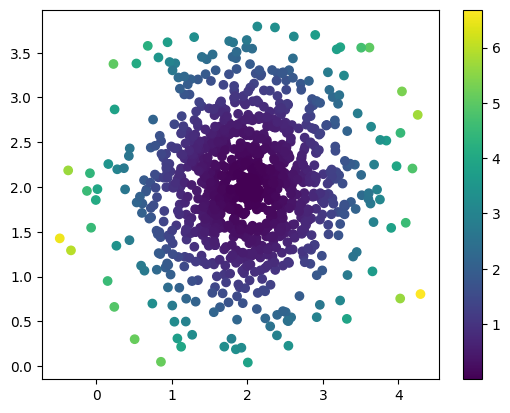

In [52]:
import torch
import pyro
from pyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt

# Define your potential function (unnormalized negative log density)
def potential_fn(x):
    x = x["x"]
    axis=0
    if len(x.shape) == 2:
        axis=1
    # Example: a simple 2D Gaussian potential
    # Negative log density of a standard normal centered at (0, 0)
    return ((x - 2) ** 2).sum(axis=axis)  # Negative log density


# Define the NUTS kernel using the potential function
nuts_kernel = NUTS(potential_fn=potential_fn)

# Alternatively, use HMC if you prefer
# hmc_kernel = HMC(potential_fn=potential_fn)

# Set up MCMC sampler
initial_params = torch.zeros(2)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, initial_params={"x": initial_params})

# Run the MCMC algorithm. Specify initial parameters.
mcmc.run(initial_params)

# Get samples from the MCMC run
samples = mcmc.get_samples()

# Access samples for each variable
plt.scatter(*samples["x"].T, c=potential_fn(samples))
plt.colorbar()
# Print some statistics
print(f"Mean of x: {samples.mean(axis=0)[0]}")
print(f"Mean of y: {samples.mean(axis=0)[1]}")

sample: 100%|██████████| 20000/20000 [00:01<00:00, 15249.32it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      1.88      0.63      1.86      0.92      2.98     48.92      1.00
Param:0[1]      2.01      0.65      2.03      0.87      2.98     49.09      1.00



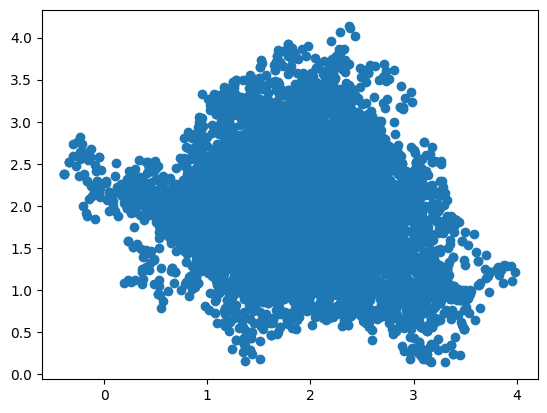

In [12]:
from collections import namedtuple
from jax import random
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC

MHState = namedtuple("MHState", ["u", "rng_key"])

class MetropolisHastings(numpyro.infer.mcmc.MCMCKernel):
    sample_field = "u"

    def __init__(self, potential_fn, step_size=0.1):
        self.potential_fn = potential_fn
        self.step_size = step_size

    def init(self, rng_key, num_warmup, init_params, model_args, model_kwargs):
        return MHState(init_params, rng_key)

    def sample(self, state, model_args, model_kwargs):
        u, rng_key = state
        rng_key, key_proposal, key_accept = random.split(rng_key, 3)
        u_proposal = dist.Normal(u, self.step_size).sample(key_proposal)
        accept_prob = jnp.exp(self.potential_fn(u) - self.potential_fn(u_proposal))
        u_new = jnp.where(dist.Uniform().sample(key_accept) < accept_prob, u_proposal, u)
        return MHState(u_new, rng_key)

def f(x):
    return ((x - 2) ** 2).sum()

kernel = MetropolisHastings(f)
mcmc = MCMC(kernel, num_warmup=10000, num_samples=10000)
mcmc.run(random.PRNGKey(0), init_params=jnp.array([1., 2.]))
posterior_samples = mcmc.get_samples()
mcmc.print_summary()  

samples = mcmc.get_samples()
import matplotlib.pyplot as plt
plt.scatter(*samples.T)

In [1]:
import torch
from gbi_diff.dataset import SBIDataset
from gbi_diff.model.lit_module import SBI
import pyro
from pyro.infer import MCMC, NUTS
from pyro.distributions import Uniform, Normal

dataset = SBIDataset.from_file("data/moon_1000.pt")
dataset.set_n_target(1000)

nn = SBI.load_from_checkpoint("results/lightning_logs/version_38/epoch=99-step=400.ckpt")

theta, x, x_target = dataset[0]


def model(x_data: torch.Tensor):
    theta = pyro.sample("theta", Uniform(torch.tensor([-1, -1], dtype=float), torch.tensor([1, 1], dtype=float)))
    prediction = nn.forward(theta.float(), x_data[None].float())
    prediction = torch.exp(-prediction)
    pyro.sample('obs', Normal(prediction, 0.1), obs=torch.tensor(x_data))

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=300, warmup_steps=200)
mcmc.run(x)

Warmup:   0%|          | 0/500 [00:00, ?it/s]/tmp/ipykernel_317584/603417247.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pyro.sample('obs', Normal(prediction, 0.01), obs=torch.tensor(x_data))
Sample: 100%|██████████| 500/500 [00:26, 18.55it/s, step size=3.47e-02, acc. prob=0.920]


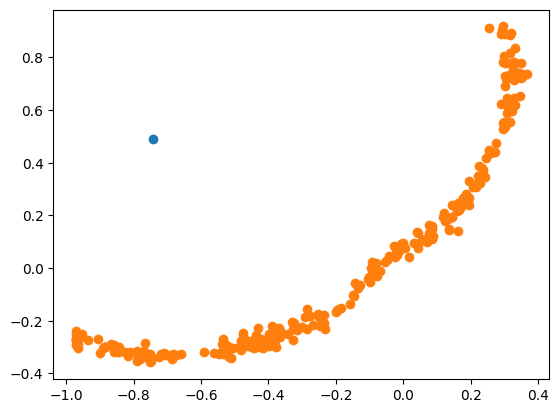

In [2]:
samples = mcmc.get_samples()
import matplotlib.pyplot as plt

plt.scatter(*theta)
plt.scatter(*samples["theta"].T)

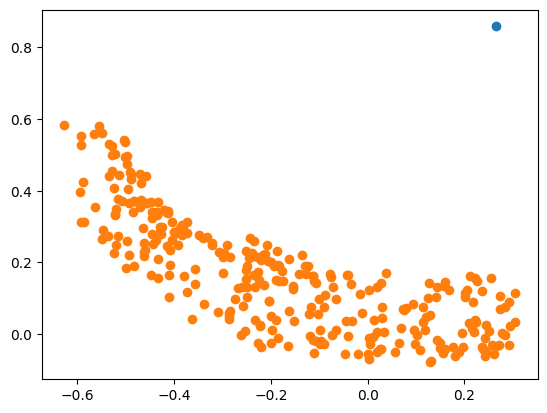

In [5]:
from sourcerer.simulators import TwoMoonsSimulator

simulator = TwoMoonsSimulator()

plt.scatter(*x)
plt.scatter(*simulator.sample(samples["theta"]).T)


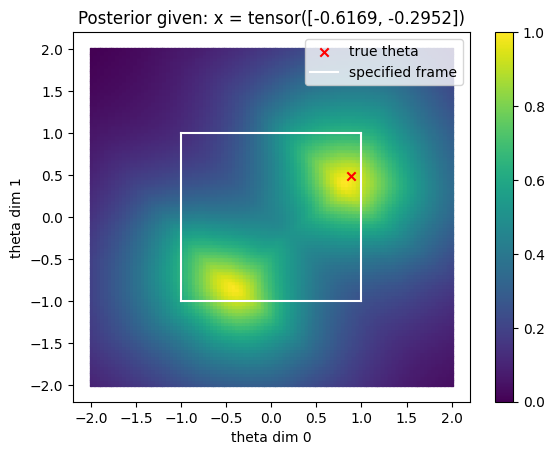

In [4]:
from gbi_diff.dataset.dataset import SBIDataset
import torch
from gbi_diff.dataset import SBIDataset
from gbi_diff.model.lit_module import SBI
import matplotlib.pyplot as plt

dataset = SBIDataset.from_file("data/two_moons_1000.pt")
dataset.set_n_target(1000)
theta, x, _ = dataset[5]
nn = SBI.load_from_checkpoint("results/two_moons/lightning_logs/version_41/epoch=99-step=400.ckpt")

prior = torch.distributions.Uniform(torch.tensor([-1, -1], dtype=float), torch.tensor([1, 1], dtype=float))

n_samples = 100
theta_grid = torch.stack(torch.meshgrid(torch.linspace(-1, 1, n_samples), torch.linspace(-1, 1, n_samples))).reshape(2, -1).T
misspecified_factor = 2
theta_grid *= misspecified_factor

x_repeat = x[None].repeat(n_samples * n_samples, 1)

likelihood = nn.forward(theta_grid, x_repeat[:, None])
likelihood = torch.exp(-likelihood)

likelihood = likelihood.squeeze().detach()
likelihood = likelihood.view(n_samples, n_samples)

plt.scatter(*theta_grid.T, c=likelihood, s=4, marker="s")
plt.scatter(*theta, marker="x", c="r", label="true theta")

if misspecified_factor > 1:
    plt.plot([-1, -1], [-1, 1], c="w")
    plt.plot([1, 1], [-1, 1], c="w")
    plt.plot([-1, 1], [1, 1], c="w")
    plt.plot([-1, 1], [-1, -1], c="w", label="specified frame")

plt.title(f"Posterior given: x = {x_repeat[0]}")
plt.xlabel("theta dim 0")
plt.ylabel("theta dim 1")
plt.colorbar()
plt.legend()

Text(0.5, 1.0, '$H(\\Theta|X = x)$')

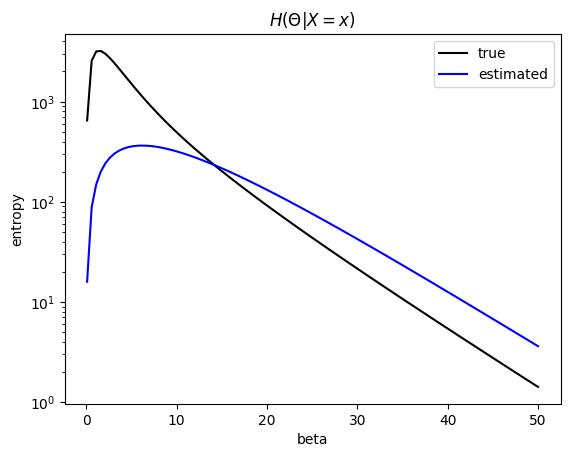

In [8]:
scores = - torch.log(likelihood).flatten()
dataset_scores = nn.forward(dataset._theta, dataset._x[:, None])

def entropy(p):
    mask = p != 0
    return -torch.dot(p[mask], torch.log(p[mask]))

betas = torch.linspace(0.1, 50, 100)
true = []
estimated = []
for beta in betas:
    true.append(entropy(torch.exp(-beta * scores)))
    estimated.append(entropy(torch.exp(-beta * dataset_scores.squeeze().detach())))

plt.plot(betas, true, c="k", label="true")
plt.plot(betas, estimated, c="b", label="estimated")
plt.yscale("log")
plt.ylabel("entropy")
plt.xlabel("beta")
plt.legend()
plt.title(r"$H(\Theta|X = x)$")

tensor([ 0.0000,  0.2000,  0.4000,  0.6000,  0.8000,  1.0000,  1.2000,  1.4000,
         1.6000,  1.8000,  2.0000,  2.2000,  2.4000,  2.6000,  2.8000,  3.0000,
         3.2000,  3.4000,  3.6000,  3.8000,  4.0000,  4.2000,  4.4000,  4.6000,
         4.8000,  5.0000,  5.2000,  5.4000,  5.6000,  5.8000,  6.0000,  6.2000,
         6.4000,  6.6000,  6.8000,  7.0000,  7.2000,  7.4000,  7.6000,  7.8000,
         8.0000,  8.2000,  8.4000,  8.6000,  8.8000,  9.0000,  9.2000,  9.4000,
         9.6000,  9.8000, 10.0000, 10.2000, 10.4000, 10.6000, 10.8000, 11.0000,
        11.2000, 11.4000, 11.6000, 11.8000, 12.0000, 12.2000, 12.4000, 12.6000,
        12.8000, 13.0000, 13.2000, 13.4000, 13.6000, 13.8000, 14.0000, 14.2000,
        14.4000, 14.6000, 14.8000, 15.0000, 15.2000, 15.4000, 15.6000, 15.8000,
        16.0000, 16.2000, 16.4000, 16.6000, 16.8000, 17.0000, 17.2000, 17.4000,
        17.6000, 17.8000, 18.0000, 18.2000, 18.4000, 18.6000, 18.8000, 19.0000,
        19.2000, 19.4000, 19.6000, 19.80

Text(0.5, 1.0, 'Uniform prior, unnormalized likelihood')

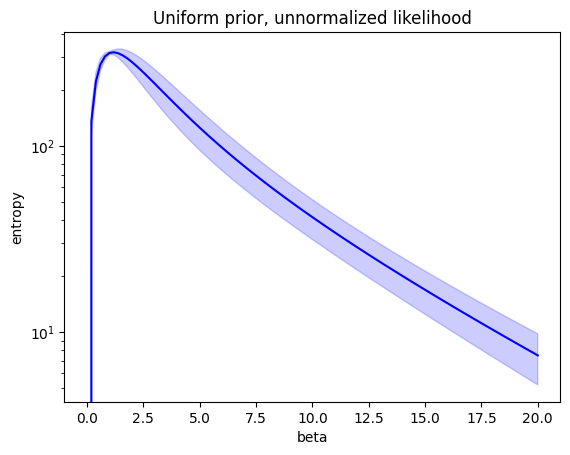

In [55]:
from gbi_diff.dataset.dataset import SBIDataset
import torch
from gbi_diff.dataset import SBIDataset
from gbi_diff.model.lit_module import SBI
import matplotlib.pyplot as plt

dataset = SBIDataset.from_file("data/moon_1000.pt")
dataset.set_n_target(1000)
nn = SBI.load_from_checkpoint("results/two_moons/lightning_logs/version_38/epoch=99-step=400.ckpt")

theta = dataset._theta
x = dataset._x
x = x[None].repeat(len(x), 1, 1)

scores = nn.forward(theta, x).squeeze().detach()

betas = torch.linspace(0, 20, 101)
means = []
stds = []
for beta in betas:
    p = torch.exp(- beta * scores)
    # p = p.flatten()
    # mask = p != 0
    entropy_base = -(p * torch.log(p))
    entropy_base[torch.isnan(entropy_base)] =0
    # plt.scatter([beta] * entropy_base.shape[0], entropy_base.sum(dim=1), c="b", s=10, label=r"$H(X|\Theta = \theta$")
    # plt.errorbar(beta, y=entropy_base.sum(dim=1).mean(), yerr=entropy_base.sum(dim=1).std(), c="b", marker="o")  # H(X|\Theta = \theta
    means.append(entropy_base.sum(dim=1).mean())
    stds.append(entropy_base.sum(dim=1).std())
    # plt.scatter([beta] * entropy_base.shape[1], entropy_base.sum(dim=0), c="r", s=10, label=r"$H(\Theta| X = x$")
    # plt.errorbar(beta, y=entropy_base.sum(dim=0).mean(), yerr=entropy_base.sum(dim=0).std(), c="r", marker="o") # same as H(x| theta) because of uniform prior

means = torch.stack(means)
stds = torch.stack(stds)

print(torch.max(means), torch.argmax(means), betas[torch.argmax(means)])
plt.plot(betas, means, c="b")
plt.fill_between(betas, means - stds, means + stds, alpha=0.2, color="b", label=r"$H(X|\Theta = \theta)$")
plt.yscale("log")
plt.ylabel("entropy")
plt.xlabel("beta")
plt.title("Uniform prior, unnormalized likelihood")

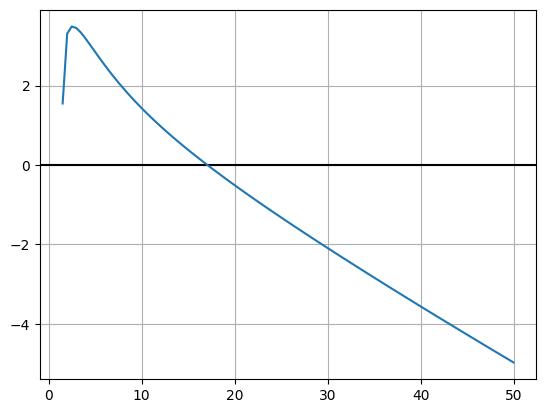

In [46]:
plt.axhline(torch.exp(-beta), c="k")
plt.plot(betas[1:], torch.log( - torch.diff(means)))
plt.grid()

In [31]:
import numpy as np

def pair_plot(data: torch.Tensor, p: torch.Tensor, param_name: str, marker: str = ".", s: int = 10):
    n_feautures = data.shape[1]
    layout = []
    for row_idx in range(n_feautures):
        row = []
        for col in range(n_feautures):
            if col > row_idx:
                insert = "."
            elif row_idx > col:
                insert = "_".join([param_name, str(col), str(row_idx)])
            elif row_idx == col:
                insert = "_".join([param_name, str(col)])
            row.append(insert)
        layout.append(row)

    fig, axes = plt.subplot_mosaic(layout)

    for key, ax in axes.items():
        split = key.split("_")
        idx = np.array(split[1:], dtype=int)
        if len(split) == 3:
            # cross plot
            ax.scatter(*data[:, idx].T, c=p, marker=marker, s=s)
            
        elif len(split) == 2:
            # histogram
            ax.hist(data[:, *idx])
        else:
            continue

In [1]:
from gbi_diff.dataset.dataset import SBIDataset
import torch
from gbi_diff.dataset import SBIDataset
from gbi_diff.model.lit_module import SBI
import pyro
from pyro.infer import MCMC, NUTS
from pyro.distributions import Uniform, Normal
import matplotlib.pyplot as plt

dataset = SBIDataset.from_file("data/moon_1000.pt")
dataset.set_n_target(1000)
theta, x, _ = dataset[5]
nn = SBI.load_from_checkpoint(
    "results/inverse_kinematics/lightning_logs/version_0/epoch=99-step=400.ckpt"
)


def create_grid(n_dim: int, n_samples: int = 100):
    return (
        torch.stack(torch.meshgrid(*[torch.linspace(-1, 1, n_samples)] * n_dim))
        .reshape(n_dim, -1)
        .T
    )


n_samples = 10
theta_grid = create_grid(4, n_samples)
print(theta_grid.shape)
misspecified_factor = 4
theta_grid *= misspecified_factor

x_repeat = x[None].repeat(n_samples * n_samples, 1)

likelihood = nn.forward(theta_grid, x_repeat[:, None])
likelihood = torch.exp(-likelihood)
likelihood = likelihood.squeeze().detach()

pair_plot(theta_grid, likelihood, marker="s", s=1)

# likelihood = likelihood.view(n_samples, n_samples)
#
# plt.scatter(*theta_grid.T, c=likelihood, s=4, marker="s")
# plt.scatter(*theta, marker="x", c="r", label="true theta")
#
# if misspecified_factor > 1:
#     plt.plot([-1, -1], [-1, 1], c="w")
#     plt.plot([1, 1], [-1, 1], c="w")
#     plt.plot([-1, 1], [1, 1], c="w")
#     plt.plot([-1, 1], [-1, -1], c="w", label="specified frame")
#
# plt.title(f"Posterior given: x = {x_repeat[0]}")
# plt.xlabel("theta dim 0")
# plt.ylabel("theta dim 1")
# plt.colorbar()
# plt.legend()

torch.Size([10000, 4])


/home/robin/miniconda3/envs/gbi/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 10000 but got size 100 for tensor number 1 in the list.